In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import glob

sys.path.append('../')

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from src.utilities.config_ import morgan_train_data_path, predicted_data_path
import src.utilities.utils as utils

In [2]:
# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(morgan_train_data_path, "*.csv"))

# Read each CSV into a DataFrame and store them in a list
dataframes = [pd.read_csv(file) for file in csv_files]

# Optionally, concatenate all DataFrames into one
df = pd.concat(dataframes, ignore_index=True).reset_index(drop=True)
df = df[df["Material Code"] == 110398316].sort_values("Inv Date")
df

,Inv Date,Inv Date (MMM-YYYY),Material Group Code,Material Group Desc,Material Code,Material Desc,Plant Code,Storage Location Code,Storage Location Desc,Payer Customer Group,Payer Customer Group 1,Payer Customer,Total COGS EA,Total COGS CTN,Total COGS Value,Sales Department Code,Inv - Net NV1,IsFestive,Status,Outlier
3,2021-01-04,Jan - 2021,179,MORGAN,110398316,MGS-7313S GAS STOVE (SS/130X130MM),MY01,2020.0,Century ...,SPECIALITY STORES TT (SG),(),U & ME ELECTRICAL SDN BHD (103021142),10,10.0,566.51,E6,1090.00,True,Active,False
89,2021-01-06,Jan - 2021,179,MORGAN,110398316,MGS-7313S GAS STOVE (SS/130X130MM),MY01,2020.0,Century ...,SPECIALITY STORES TT (SG),(),SYARIKAT ELEKTRIK SIANG SDN BHD (103020975),5,5.0,283.26,E6,475.30,True,Active,False
436,2021-01-15,Jan - 2021,179,MORGAN,110398316,MGS-7313S GAS STOVE (SS/130X130MM),MY01,2020.0,Century ...,SPECIALITY STORES TT (SG),(),MODERN MISSION SDN BHD (103020313),4,4.0,226.60,E6,450.00,False,Active,False
501,2021-01-18,Jan - 2021,179,MORGAN,110398316,MGS-7313S GAS STOVE (SS/130X130MM),MY01,2020.0,Century ...,ELECTRICAL SHOP (E2),(),IMPERIUM PROPERTIES SDN BHD (103028894),30,30.0,1699.53,E6,3180.00,False,Active,False
502,2021-01-18,Jan - 2021,179,MORGAN,110398316,MGS-7313S GAS STOVE (SS/130X130MM),MY01,2020.0,Century ...,SPECIALITY STORES TT (SG),(),PERNIAGAAN ELEKTRIK & PERABUT UTAMA (103031064),5,5.0,283.26,E6,562.50,False,Active,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54504,2024-11-29,Nov - 2024,179,MORGAN,110398316,MGS-7313S GAS STOVE (SS/130X130MM),MY01,1173.0,NE Sound ...,SPECIALITY STORES (SG),(),TBC ELEKTRIK SDN BHD (103020962),24,24.0,1508.25,E6,2136.00,False,Active,False
54964,2024-12-18,Dec - 2024,179,MORGAN,110398316,MGS-7313S GAS STOVE (SS/130X130MM),MY01,1173.0,NE Sound ...,ELECTRICAL SHOP (E2),(),LITSON ELECTRONIC TRADING SDN BHD (103031725),16,16.0,1005.49,E6,1470.00,True,Active,False
55067,2024-12-26,Dec - 2024,179,MORGAN,110398316,MGS-7313S GAS STOVE (SS/130X130MM),MY01,1173.0,NE Sound ...,SPECIALITY STORES (SG),(),SYARIKAT ELEKTRIK SIANG SDN BHD (103020975),4,4.0,251.38,E6,306.00,True,Active,False
55189,2024-12-27,Dec - 2024,179,MORGAN,110398316,MGS-7313S GAS STOVE (SS/130X130MM),MY01,1173.0,NE Sound ...,SPECIALITY STORES (SG),(),TBC ELEKTRIK SDN BHD (103020962),33,33.0,2073.81,E6,2937.00,True,Active,False


Running 1/12 → COLUMN=AVG Total RM, STORAGE_TYPE=All, OUTLIER=True


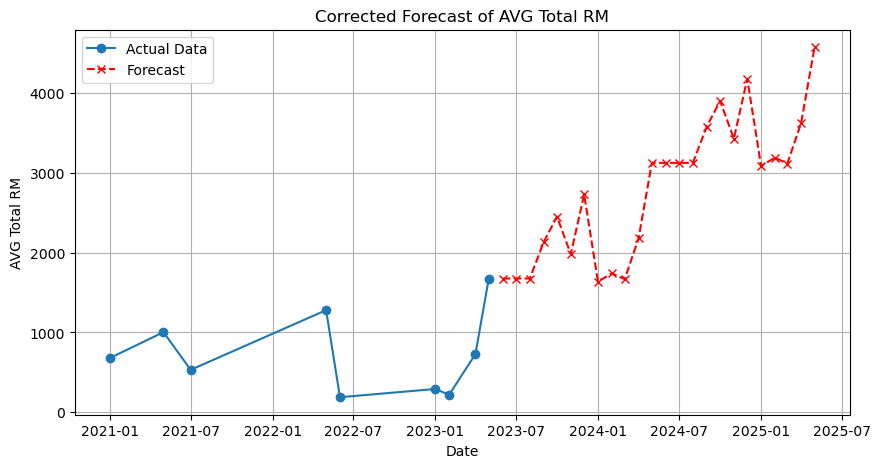

In [7]:

# Hyperparameters :)
COLUMN = ["AVG Total RM"]
STORAGE_TYPE = ["All"]
OUTLIER = [True]

# Store a new empty list for the final result
results = []

# Iterate over all parameter combinations
for idx, (col, storage_type, outlier) in enumerate(product(COLUMN, STORAGE_TYPE, OUTLIER), start=1):
    print(f"Running {idx}/12 → COLUMN={col}, STORAGE_TYPE={storage_type}, OUTLIER={outlier}")
    # Preprocess data once per OUTLIER setting
    df_grouped = utils.preprocess_df(df, outlier)

    # Apply grouping if storage_type is "All"
    if storage_type != "Specific":
        df_grouped = utils.all_storage_grouper(df_grouped)
        material_storage_pairs = ((m, None) for m in df_grouped["Material Code"].unique())  # Use (material, None) pairs
    else:
        material_storage_pairs = product(df_grouped["Material Code"].unique(), df_grouped["Storage Location Code"].unique())

    # Iterate over material-storage pairs (up to LOOP_VALUE)
    for i, (material, storage) in enumerate(material_storage_pairs):
        if False:
            if i >= 1: 
                break  # Stop early if LOOP_VALUE is reached

        # Efficient DataFrame filtering using .query()
        if storage:
            df_sample = df_grouped.query("`Material Code` == @material and `Storage Location Code` == @storage")
        else:
            df_sample = df_grouped.query("`Material Code` == @material")

        # Skip if DataFrame is empty
        if df_sample.empty:
            continue

        try:
            # Train and forecast
            forecast = utils.train_predict(df_sample, col)

            # Post-process and plot results
            future_dates = utils.postprocess(df_sample, forecast, col, True)

            # Determine COGS Type
            cogs_type = "RM" if col == "AVG Total RM" else "EA" if col == "AVG Total EA" else "CTN"

            # Store results
            results.extend([
                {
                    "Date": future_date,
                    "Material Code": material,
                    "Storage Location Code": storage if storage else "All",
                    "COGS Type": cogs_type,
                    "COGS Value": value,
                    "Outlier": outlier
                }
                for future_date, value in zip(future_dates, forecast)
            ])

            print()

        except Exception as error:
            print(f"⚠️ Error for Material {material}: {error}")
            continue

# Convert results list into a DataFrame
df_results = pd.DataFrame(results)

# Postprocess data type
df_results["Storage Location Code"] = df_results["Storage Location Code"].astype(str)

In [45]:
df_grouped = df.groupby(['Inv Date (MMM-YYYY)', 'Material Code', 'Storage Location Code'], as_index=False).agg(
    {
        'Total COGS EA': 'mean',
        'Total COGS CTN': 'mean',
        'Total COGS Value': 'mean',
        'Outlier': 'first'  # Keeps the first Outlier flag (modify if needed)
    }  # Computes avg COGS and keeps first Outlier flag
)
df_grouped = df_grouped[df_grouped["Outlier"] == True]
df_grouped

,Inv Date (MMM-YYYY),Material Code,Storage Location Code,Total COGS EA,Total COGS CTN,Total COGS Value,Outlier
20,Jul - 2021,110398316,2020.0,12.25,12.25,722.7275,True
26,Jun - 2022,110398316,2021.0,0.00,0.00,0.0000,True


In [42]:
df_outlier = df[df["Outlier"] == True]
df_grouped = df_outlier.groupby(['Inv Date (MMM-YYYY)', 'Material Code', 'Storage Location Code'], as_index=False).agg(
    {
        'Total COGS EA': 'mean',
        'Total COGS CTN': 'mean',
        'Total COGS Value': 'mean',
        'Outlier': 'first'  # Keeps the first Outlier flag (modify if needed)
    }  # Computes avg COGS and keeps first Outlier flag
)
df_grouped

,Inv Date (MMM-YYYY),Material Code,Storage Location Code,Total COGS EA,Total COGS CTN,Total COGS Value,Outlier
0,Apr - 2023,110398316,2020.0,10.0,10.0,728.320000,True
1,Feb - 2023,110398316,2020.0,3.0,3.0,218.500000,True
2,Jan - 2021,110398316,2020.0,12.0,12.0,679.800000,True
3,Jan - 2023,110398316,2020.0,4.0,4.0,291.323333,True
4,Jul - 2021,110398316,2020.0,9.0,9.0,530.990000,True
5,Jun - 2022,110398316,2020.0,5.0,5.0,376.170000,True
6,Jun - 2022,110398316,2021.0,0.0,0.0,0.000000,True
7,May - 2021,110398316,2020.0,17.0,17.0,1002.970000,True
8,May - 2022,110398316,2020.0,17.0,17.0,1278.970000,True
9,May - 2023,110398316,2020.0,23.0,23.0,1675.140000,True


In [32]:
df_grouped

,Inv Date (MMM-YYYY),Material Code,Storage Location Code,AVG Total EA,AVG Total CTN,AVG Total RM,Outlier,Date
4,Jul - 2021,110398316,2020.0,12.25,12.25,722.7275,True,2021-07-01
15,Jun - 2022,110398316,2021.0,0.00,0.00,0.0000,True,2022-06-01
